# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Data Insights

 Download Data Set: https://www.kaggle.com/competitions/tabular-playground-series-sep-2022/data

In [2]:
datafile_train = "train.csv"
train_df = pd.read_csv(datafile_train, sep=',')
datafile_test = "test.csv"
test_df = pd.read_csv(datafile_test, sep=',')

In [3]:
train_df['date']= pd.to_datetime(train_df['date'])
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70128 entries, 0 to 70127
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   row_id    70128 non-null  int64         
 1   date      70128 non-null  datetime64[ns]
 2   country   70128 non-null  object        
 3   store     70128 non-null  object        
 4   product   70128 non-null  object        
 5   num_sold  70128 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 3.2+ MB


In [4]:
test_df['date']= pd.to_datetime(test_df['date'])
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17520 entries, 0 to 17519
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   row_id   17520 non-null  int64         
 1   date     17520 non-null  datetime64[ns]
 2   country  17520 non-null  object        
 3   store    17520 non-null  object        
 4   product  17520 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 684.5+ KB


In [5]:
display(train_df.head())
display(test_df.head())

,row_id,date,country,store,product,num_sold
0,0,2017-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques,663
1,1,2017-01-01,Belgium,KaggleMart,Kaggle Getting Started,615
2,2,2017-01-01,Belgium,KaggleMart,Kaggle Recipe Book,480
3,3,2017-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose,710
4,4,2017-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques,240


,row_id,date,country,store,product
0,70128,2021-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques
1,70129,2021-01-01,Belgium,KaggleMart,Kaggle Getting Started
2,70130,2021-01-01,Belgium,KaggleMart,Kaggle Recipe Book
3,70131,2021-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose
4,70132,2021-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques


In [17]:
display(train_df['country'].value_counts())
display(train_df['store'].value_counts())
display(train_df['product'].value_counts())

Belgium    11688
France     11688
Germany    11688
Italy      11688
Poland     11688
Spain      11688
Name: country, dtype: int64

KaggleMart    35064
KaggleRama    35064
Name: store, dtype: int64

Kaggle Advanced Techniques          17532
Kaggle Getting Started              17532
Kaggle Recipe Book                  17532
Kaggle for Kids: One Smart Goose    17532
Name: product, dtype: int64

In [19]:
train_df.groupby(["country","store","product"])["num_sold"].count()

country  store       product                         
Belgium  KaggleMart  Kaggle Advanced Techniques          1461
                     Kaggle Getting Started              1461
                     Kaggle Recipe Book                  1461
                     Kaggle for Kids: One Smart Goose    1461
         KaggleRama  Kaggle Advanced Techniques          1461
                     Kaggle Getting Started              1461
                     Kaggle Recipe Book                  1461
                     Kaggle for Kids: One Smart Goose    1461
France   KaggleMart  Kaggle Advanced Techniques          1461
                     Kaggle Getting Started              1461
                     Kaggle Recipe Book                  1461
                     Kaggle for Kids: One Smart Goose    1461
         KaggleRama  Kaggle Advanced Techniques          1461
                     Kaggle Getting Started              1461
                     Kaggle Recipe Book                  1461
                

In [9]:
daily_df = train_df.groupby(["country","store", "product", pd.Grouper(key="date")])["num_sold"].sum()
daily_df = daily_df.to_frame().reset_index(level=[3])
daily_df

date  num_sold
country store      product                                              
Belgium KaggleMart Kaggle Advanced Techniques       2017-01-01       663
                   Kaggle Advanced Techniques       2017-01-02       514
                   Kaggle Advanced Techniques       2017-01-03       549
                   Kaggle Advanced Techniques       2017-01-04       477
                   Kaggle Advanced Techniques       2017-01-05       447
...                                                        ...       ...
Spain   KaggleRama Kaggle for Kids: One Smart Goose 2020-12-27       204
                   Kaggle for Kids: One Smart Goose 2020-12-28       212
                   Kaggle for Kids: One Smart Goose 2020-12-29       242
                   Kaggle for Kids: One Smart Goose 2020-12-30       239
                   Kaggle for Kids: One Smart Goose 2020-12-31       202

[70128 rows x 2 columns]

In [10]:
print("Train - Earliest date:", train_df["date"].min())
print("Train - Latest date:", train_df["date"].max())

print("Test - Earliest date:", test_df["date"].min())
print("Test - Latest date:", test_df["date"].max())

Train - Earliest date: 2017-01-01 00:00:00
Train - Latest date: 2020-12-31 00:00:00
Test - Earliest date: 2021-01-01 00:00:00
Test - Latest date: 2021-12-31 00:00:00


We have 4 years of data from 2017-01-01 to 2020-12-31 to train occurring at daily frequency.
We are required to forecast 1 year of data, from 2021-01-01 to 2021-12-31

# Data Transformation: Univariate Time Series

In [21]:
# Getting the 48 columns
columns = []
for i in range(daily_df.shape[0]):
    columns.append(' & '.join([str(elem) for elem in list(daily_df.index[i])]))
columns = set(columns)
columns = [column for column in columns]
print(f'There are {len(columns)} columns')
print(columns)

There are 48 columns
['Germany & KaggleMart & Kaggle Advanced Techniques', 'Belgium & KaggleRama & Kaggle Getting Started', 'Belgium & KaggleRama & Kaggle for Kids: One Smart Goose', 'Italy & KaggleMart & Kaggle for Kids: One Smart Goose', 'France & KaggleMart & Kaggle Advanced Techniques', 'Poland & KaggleRama & Kaggle for Kids: One Smart Goose', 'France & KaggleRama & Kaggle for Kids: One Smart Goose', 'Italy & KaggleRama & Kaggle for Kids: One Smart Goose', 'Poland & KaggleRama & Kaggle Recipe Book', 'Italy & KaggleRama & Kaggle Recipe Book', 'Germany & KaggleMart & Kaggle Getting Started', 'Italy & KaggleMart & Kaggle Advanced Techniques', 'Italy & KaggleMart & Kaggle Getting Started', 'Poland & KaggleRama & Kaggle Getting Started', 'France & KaggleMart & Kaggle for Kids: One Smart Goose', 'Belgium & KaggleMart & Kaggle Getting Started', 'Italy & KaggleRama & Kaggle Getting Started', 'Belgium & KaggleMart & Kaggle Recipe Book', 'Germany & KaggleRama & Kaggle Getting Started', 'Germ

In [26]:
# Generating a new DataFrame
new_train_df = pd.DataFrame(index = train_df['date'].unique(), columns = columns)
new_train_df

,Germany & KaggleMart & Kaggle Advanced Techniques,Belgium & KaggleRama & Kaggle Getting Started,Belgium & KaggleRama & Kaggle for Kids: One Smart Goose,Italy & KaggleMart & Kaggle for Kids: One Smart Goose,France & KaggleMart & Kaggle Advanced Techniques,Poland & KaggleRama & Kaggle for Kids: One Smart Goose,France & KaggleRama & Kaggle for Kids: One Smart Goose,Italy & KaggleRama & Kaggle for Kids: One Smart Goose,Poland & KaggleRama & Kaggle Recipe Book,Italy & KaggleRama & Kaggle Recipe Book,...,Spain & KaggleRama & Kaggle Advanced Techniques,Germany & KaggleRama & Kaggle Recipe Book,Poland & KaggleRama & Kaggle Advanced Techniques,Spain & KaggleRama & Kaggle Getting Started,Spain & KaggleRama & Kaggle for Kids: One Smart Goose,Spain & KaggleMart & Kaggle for Kids: One Smart Goose,France & KaggleRama & Kaggle Recipe Book,France & KaggleRama & Kaggle Getting Started,Italy & KaggleMart & Kaggle Recipe Book,Germany & KaggleMart & Kaggle for Kids: One Smart Goose
2017-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
# Writing the values (very inefficient XD)
for column in new_train_df.columns:
    i = 0
    for row in range(daily_df.shape[0]):
        if column == ' & '.join([str(elem) for elem in list(daily_df.index[row])]):
            new_train_df.iloc[i, new_train_df.columns.get_loc(column)] = daily_df.num_sold[row]
            i += 1
new_train_df

,Germany & KaggleMart & Kaggle Advanced Techniques,Belgium & KaggleRama & Kaggle Getting Started,Belgium & KaggleRama & Kaggle for Kids: One Smart Goose,Italy & KaggleMart & Kaggle for Kids: One Smart Goose,France & KaggleMart & Kaggle Advanced Techniques,Poland & KaggleRama & Kaggle for Kids: One Smart Goose,France & KaggleRama & Kaggle for Kids: One Smart Goose,Italy & KaggleRama & Kaggle for Kids: One Smart Goose,Poland & KaggleRama & Kaggle Recipe Book,Italy & KaggleRama & Kaggle Recipe Book,...,Spain & KaggleRama & Kaggle Advanced Techniques,Germany & KaggleRama & Kaggle Recipe Book,Poland & KaggleRama & Kaggle Advanced Techniques,Spain & KaggleRama & Kaggle Getting Started,Spain & KaggleRama & Kaggle for Kids: One Smart Goose,Spain & KaggleMart & Kaggle for Kids: One Smart Goose,France & KaggleRama & Kaggle Recipe Book,France & KaggleRama & Kaggle Getting Started,Italy & KaggleMart & Kaggle Recipe Book,Germany & KaggleMart & Kaggle for Kids: One Smart Goose
2017-01-01,700,187,267,534,610,92,255,187,50,124,...,159,163,79,123,181,451,140,172,346,826
2017-01-02,537,158,196,409,455,67,180,152,40,85,...,124,134,55,104,123,379,101,131,245,594
2017-01-03,510,131,188,361,465,61,161,127,35,91,...,113,119,60,87,125,335,101,114,245,558
2017-01-04,417,134,169,367,465,55,163,115,35,83,...,114,114,51,84,110,316,102,119,234,524
2017-01-05,484,129,169,391,385,53,164,119,32,69,...,99,115,49,72,104,271,97,114,212,540
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-27,562,160,228,612,552,223,225,219,139,148,...,199,131,186,160,204,629,133,171,412,693
2020-12-28,638,168,200,644,574,238,219,213,153,131,...,198,126,210,168,212,655,132,146,439,634
2020-12-29,636,192,248,728,615,251,232,263,163,160,...,234,157,232,182,242,711,150,192,443,725
2020-12-30,666,183,237,721,621,250,224,251,168,169,...,232,169,235,170,239,655,130,178,508,763


In [50]:
# Save the CSV file
new_train_df.to_csv('new_train.csv')

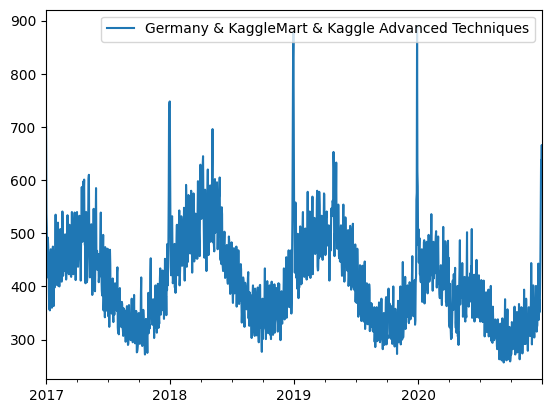

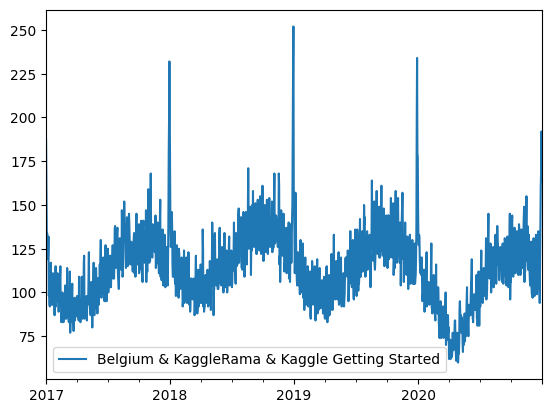

In [51]:
# Plotting some example series
for column in columns[0:2]:
    new_train_df.plot(y=column)

In [52]:
# Reading the CSV file
new_train_df = pd.read_csv('new_test.csv', infer_datetime_format=True, index_col=0 , header=0)

In [53]:
# This function normalizes the dataset using min max scaling.
def normalize_series(data, min, max):
    data = data - min
    data = data / max
    return data

In [62]:
# Number of features in the dataset. We use all features as predictors to predict all features of future time steps.
N_FEATURES = len(new_train_df.columns)

# Normalizes the data
data = new_train_df.values
data = normalize_series(data, data.min(axis=0), data.max(axis=0))

# Splits the data into training and validation sets.
SPLIT_TIME = int(len(data) * 0.8)
x_train = data[:SPLIT_TIME]
x_valid = data[SPLIT_TIME:]

data

array([[0.49831271, 0.50396825, 0.5152439 , ..., 0.56372549, 0.42519685,
        0.55172414],
       [0.31496063, 0.38888889, 0.29878049, ..., 0.3627451 , 0.22637795,
        0.31643002],
       [0.28458943, 0.28174603, 0.27439024, ..., 0.27941176, 0.22637795,
        0.27991886],
       ...,
       [0.42632171, 0.52380952, 0.45731707, ..., 0.66176471, 0.61614173,
        0.44929006],
       [0.46006749, 0.48809524, 0.42378049, ..., 0.59313725, 0.74409449,
        0.48782961],
       [0.40832396, 0.41269841, 0.375     , ..., 0.53431373, 0.56692913,
        0.38032454]])

In [32]:
print(type(data), data.shape)

<class 'numpy.ndarray'> (1461, 48)


In [63]:
# Auxiliary plotting function
def plot_series(x, y, format="-", start=0, end=None, title=None, xlabel=None, ylabel=None, legend=None ):
    plt.figure(figsize=(10, 6))
    if type(y) is tuple:
        for y_curr in y:
            plt.plot(x[start:end], y_curr[start:end], format)
    else:
        plt.plot(x[start:end], y[start:end], format)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if legend:
        plt.legend(legend)
    plt.title(title)
    plt.grid(True)
    plt.show()

(1168,) (1168, 48)


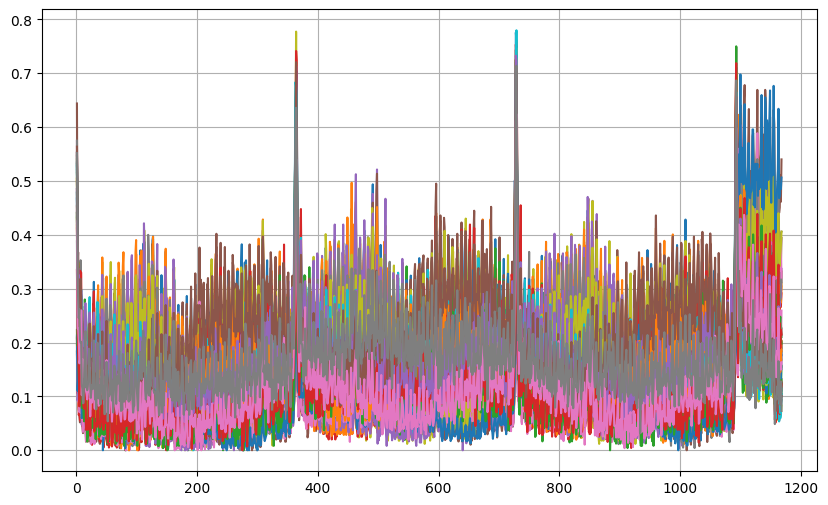

In [64]:
# Plotting the Train set
time_train = np.array([x for x in range(1, SPLIT_TIME+1)])
print(time_train.shape, x_train.shape)
plot_series(time_train, x_train, xlabel='', ylabel='')

(293,) (293, 48)


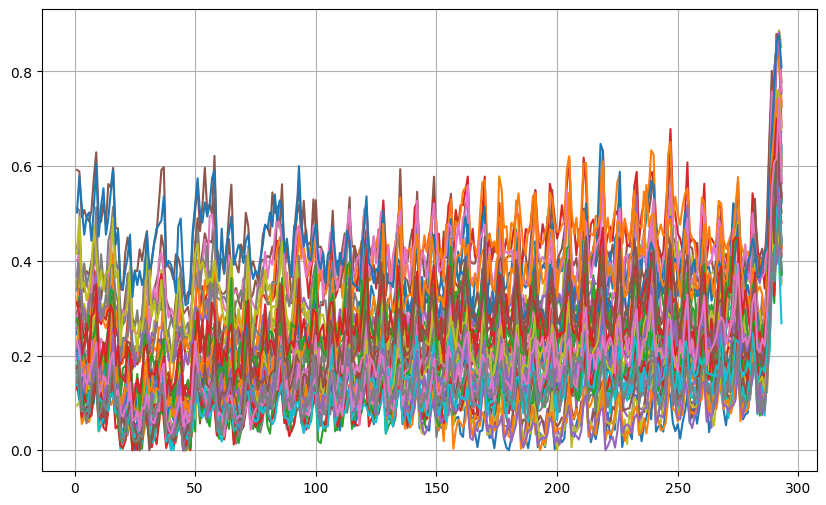

In [65]:
# Plotting the Val/Dev set
time_valid = np.array([x for x in range(1, len(data) - SPLIT_TIME+1)])
print(time_valid.shape, x_valid.shape)
plot_series(time_valid, x_valid, xlabel='', ylabel='')

# Bidirectional LSTM Model

In [66]:
# Hyper-Parameters
BATCH_SIZE = 32 # Batch size
N_PAST = 10 # Number of past time steps based on which future observations should be predicted
N_FUTURE = 10 # Number of future time steps which are to be predicted.
SHIFT = 1 # By how many positions the window slides to create a new window of observations.

In [67]:
# For a window of n_past number of observations of the time indexed variable in the dataset, the target for the window is the next
# n_future number of observations of the variable, after the end of the window.

def windowed_dataset(series, batch_size, n_past=10, n_future=10, shift=1):
    # Generate a TF Dataset from the series values
    ds = tf.data.Dataset.from_tensor_slices(series)
    # Window the data but only take those with the specified size
    ds = ds.window(size=n_past + n_future, shift=shift, drop_remainder=True)
    # Flatten the windows by putting its elements in a single batch
    ds = ds.flat_map(lambda w: w.batch(n_past + n_future))
    # Create tuples with features and labels
    ds = ds.map(lambda w: (w[:n_past], w[n_past:])) #(window[:-1], window[-1])
    # Create batches of windows
    dataset = ds.batch(batch_size).prefetch(1)

    return dataset

In [68]:
# Windowed train and validation datasets.
train_set = windowed_dataset(x_train, BATCH_SIZE, N_PAST, N_FUTURE, SHIFT)
valid_set = windowed_dataset(x_valid, BATCH_SIZE, N_PAST, N_FUTURE, SHIFT)

In [69]:
# Print the data shape
for window in train_set.take(1):
    print(f'Shape of feature: {window[0].shape}')
    print(f'Shape of label: {window[1].shape}')

Shape of feature: (32, 10, 48)
Shape of label: (32, 10, 48)


In [72]:
# This function defines, compiles, trains and returns the final model.

def solution_model():
    class MyCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs={}):
        # Check the validation set MAE
            if logs.get('val_mae') < 0.01:
                # Stop if threshold is met
                print("\nRequired val MAE is met so cancelling training!")
                self.model.stop_training = True
        def on_epoch_begin(self, epoch, logs={}):
            print("Learning Rate: {}".format(self.model.optimizer._decayed_lr(tf.float32).numpy()))
    # Instantiate the class
    callbacks = MyCallback()

    def decayed_learning_rate(step):
        return initial_learning_rate * decay_rate ^ (step / decay_steps)

    # Code to define your model.
    model = tf.keras.models.Sequential([
    # tf.keras.layers.Conv1D(filters=64, kernel_size=3, strides=1, activation="relu", padding='causal', input_shape=[N_PAST, N_FEATURES]),
    tf.keras.layers.Input(shape=(N_PAST, N_FEATURES)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(N_FEATURES),
    ])

    # Input Shape
    config = model.get_config() # Returns pretty much every information about your model
    print('Input Shape:', config["layers"][0]["config"]["batch_input_shape"]) # returns a tuple of width, height and channels

    # Model Summary
    model.summary()

    # Code to train and compile the model
    initial_learning_rate = 1e-1
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate, decay_steps=400, decay_rate=0.96, staircase=True)
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)
    #optimizer = tf.keras.optimizers.SGD(learning_rate=1e-2, momentum=0.9)
    model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])
    history = model.fit(train_set, epochs=500, validation_data=valid_set, callbacks=[callbacks])

    return model, history

In [73]:
model, history = solution_model()

Input Shape: (None, 10, 48)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_5 (Bidirectio  (None, 10, 256)          181248    
 nal)                                                            
                                                                 
 bidirectional_6 (Bidirectio  (None, 10, 128)          164352    
 nal)                                                            
                                                                 
 bidirectional_7 (Bidirectio  (None, 10, 64)           41216     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 10, 48)            3120      
                                                                 
Total params: 389,936
Trainable params: 389,936
Non-trainable params: 0
____________________

(0.01, 1.0, 0.01, 0.2)

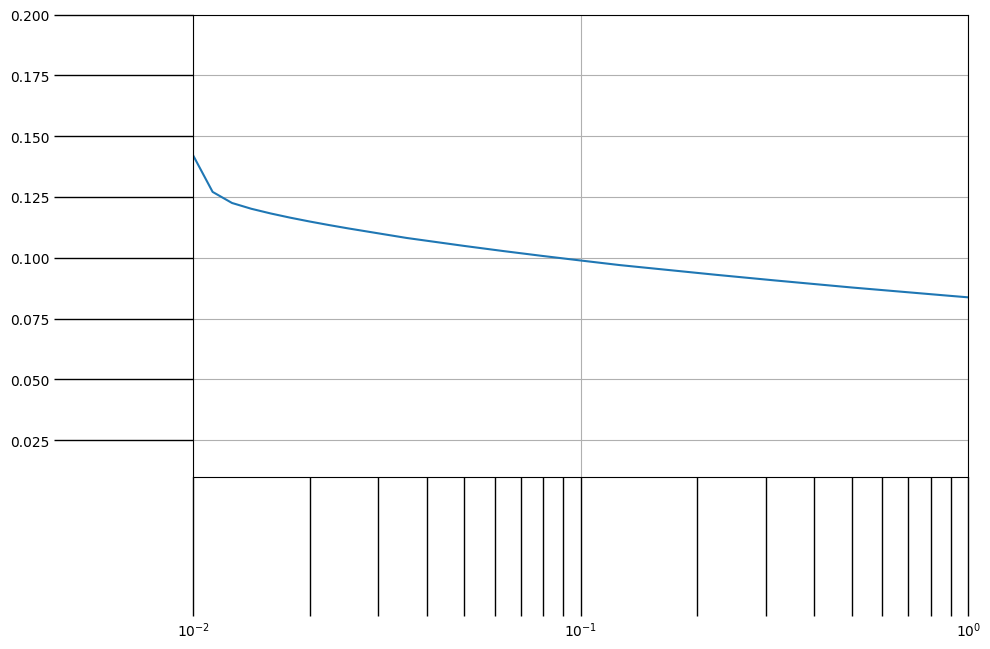

In [83]:
lrs = 1e-2 * (10 ** (np.arange(500) / 20))
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.semilogx(lrs, history.history["val_mae"])
plt.tick_params('both', length=100, width=1, which='both')
plt.axis([1e-2, 1e-0, 0.01, 0.2])

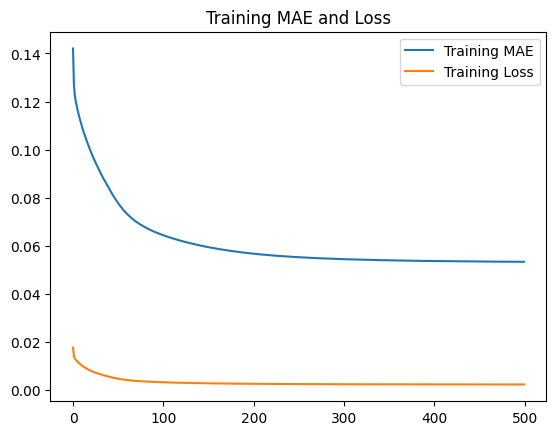

<Figure size 640x480 with 0 Axes>

In [84]:
def plot_acc_val(history):
    mae = history.history['val_mae']
    loss = history.history['val_loss']
    # Get number of epochs
    epochs = range(len(mae))

    # Plot training and validation accuracy per epoch
    plt.plot(epochs, mae, label='Training MAE')
    plt.plot(epochs, loss, label='Training Loss')
    plt.title('Training MAE and Loss')
    plt.legend()
    plt.figure()

plot_acc_val(history)

# Forcasting

In [86]:
def model_forecast(model, series, window_size, batch_size):

    # Generate a TF Dataset from the series values
    ds = tf.data.Dataset.from_tensor_slices(series)
    # Window the data but only take those with the specified size
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    # Flatten the windows by putting its elements in a single batch
    ds = ds.flat_map(lambda w: w.batch(window_size))
    # Create batches of windows
    ds = ds.batch(batch_size, drop_remainder=True).prefetch(1)
    # Get predictions on the entire dataset
    forecast = model.predict(ds)

    return forecast

In [98]:
# First Prediction
forecast = model_forecast(model, data, N_PAST, BATCH_SIZE)
print('Output shape:', forecast[0].shape)
print('First prediction: \n', forecast[0])

45/45 [==============================] - 1s 24ms/step
Output shape: (10, 48)
First prediction: 
 [[0.23208547 0.22824694 0.2166951  0.16338272 0.20617193 0.07329466
  0.1675403  0.14994109 0.07634553 0.17927781 0.23993511 0.21883284
  0.15413424 0.0987148  0.17198007 0.2484631  0.18741873 0.2241584
  0.22215891 0.22016743 0.20533389 0.07502051 0.1611228  0.19172776
  0.07057302 0.23143551 0.14433478 0.21478297 0.25734514 0.22996038
  0.1559848  0.23795465 0.24555606 0.23222381 0.2267589  0.08682387
  0.07189309 0.20362929 0.18846944 0.22511938 0.09169336 0.1455922
  0.11342467 0.10860267 0.22808282 0.22864157 0.14388606 0.18073644]
 [0.22823006 0.23231746 0.20911571 0.15770504 0.20861843 0.06177284
  0.1647909  0.15177241 0.06789054 0.17886901 0.23164597 0.21336955
  0.15473488 0.09434286 0.16607328 0.24518341 0.1719281  0.23214693
  0.21578515 0.21250606 0.2064186  0.07614695 0.15579343 0.18994018
  0.07455315 0.22820885 0.14678377 0.21162146 0.25028592 0.23507938
  0.15769503 0.24530

45/45 [==============================] - 1s 20ms/step
(281, 48) (281, 48)
Validation MAE: 0.056


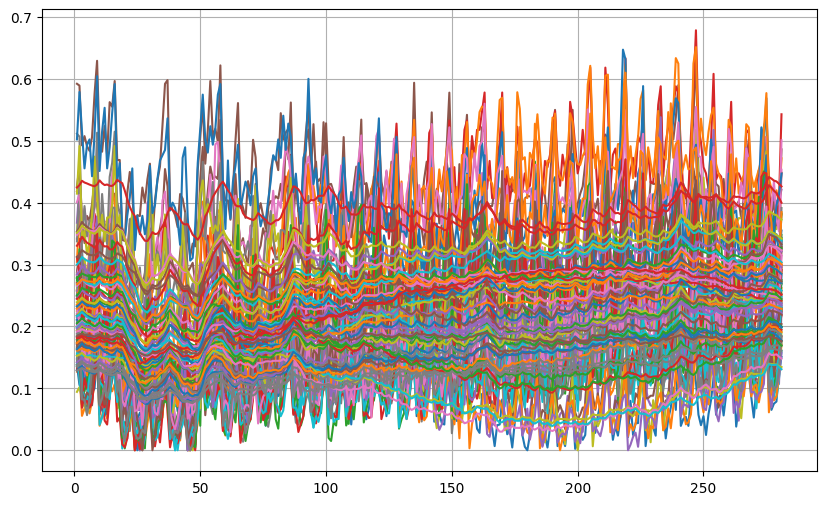

In [135]:
# PASS THE NORMALIZED data IN THE FOLLOWING CODE
forecast = model_forecast(model, data, N_PAST, BATCH_SIZE)
forecast = forecast[SPLIT_TIME - N_PAST:-1, 0, :]
x_valid = x_valid[:forecast.shape[0]]

print(forecast.shape, x_valid.shape)

# Compute the MAE
MAE = tf.keras.metrics.MeanAbsoluteError()
MAE.update_state(x_valid[:,:], forecast[:,:])
MAE = MAE.result().numpy()
print('Validation MAE:', round(MAE, 4))

# Plot the results
plot_series(np.squeeze(time_valid)[:x_valid.shape[0]], (x_valid, forecast))